In [1]:
import os
import sys

sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision as tv
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm

from defences.baard import ApplicabilityStage, ReliabilityStage, DecidabilityStage, BAARDOperator
from models.mnist import BaseModel
from models.cifar10 import Resnet
from models.torch_util import predict_numpy
from defences.util import get_correct_examples

In [4]:
PATH_DATA = os.path.join('..', 'data')
PATH = os.path.join('..', 'result_0')
N_CLASSES = 10
DATA = 'cifar10'
MODEL_NAME = 'resnet'

ATTACK = 'cw2'
EPS = 0

In [5]:
# Load model
transform = tv.transforms.Compose([tv.transforms.ToTensor()])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if DATA == 'mnist':
    model = BaseModel(use_prob=True).to(device)
    dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transform)
else:
    model = Resnet(use_prob=True).to(device)
    dataset_train = datasets.CIFAR10(PATH_DATA, train=True, download=True, transform=transform)
file_model = os.path.join(PATH, '{}_{}_model.pt'.format(DATA, MODEL_NAME))
model.load_state_dict(torch.load(file_model))

Files already downloaded and verified


<All keys matched successfully>

In [6]:

tensor_X, tensor_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
X_train = tensor_X.detach().numpy()
y_train = tensor_y.detach().numpy()

In [7]:
# Initialize BAARD
stages = []
stages.append(ApplicabilityStage(n_classes=N_CLASSES))
stages.append(ReliabilityStage(n_classes=N_CLASSES))
stages.append(DecidabilityStage(n_classes=N_CLASSES))
detector = BAARDOperator(stages=stages)

In [8]:
# Load training data
file_baard_train = os.path.join(PATH, '{}_{}_baard_s1_train_data.pt'.format(DATA, MODEL_NAME))
obj = torch.load(file_baard_train)
X_baard_train = obj['X']
y_baard_train = obj['y']

In [9]:
# Load thresholds
file_baard_threshold = os.path.join(PATH, '{}_{}_baard_threshold.pt'.format(DATA, MODEL_NAME))
detector.load(file_baard_threshold)

Load from: ../result_0/cifar10_resnet_baard_threshold.pt


In [10]:
stages[0].fit(X_baard_train, y_baard_train)
stages[1].fit(X_train, y_train)
stages[2].fit(X_train, y_train)

In [32]:
file_data = os.path.join(PATH, '{}_{}_{}_{}.pt'.format(DATA, MODEL_NAME, ATTACK, EPS))
obj = torch.load(file_data)
X = obj['X']
y = obj['y']
adv = obj['adv']

print(X.shape, y.shape, adv.shape)

print(file_data)

(6000, 3, 32, 32) (6000,) (6000, 3, 32, 32)
../result_0/cifar10_resnet_cw2_0.pt


In [12]:
pred_adv = predict_numpy(model, adv, device)

np.mean(pred_adv == y)

0.0

In [13]:
X_def_test = (X[:1000])[:100]
y_def_test = (y[:1000])[:100]
adv_def_test = (adv[:1000])[:100]
pred_adv_def_test = (pred_adv[:1000])[:100]
    
X_def_val = (X[1000:2000])[:100]
y_def_val = (y[1000:2000])[:100]
adv_def_val = (adv[1000:2000])[:100]
pred_adv_def_val = (pred_adv[1000:2000])[:100]

In [14]:
stage = 0
output_adv = stages[stage].predict(adv_def_val, pred_adv_def_val)
output_X = stages[stage].predict(X_def_val, y_def_val)
print('\nTPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Applicability: 100%|██████████| 10/10 [00:00<00:00, 9894.56it/s]
TPR 1 FPR: 1



In [15]:
stage = 1
output_adv = stages[stage].predict(adv_def_val, pred_adv_def_val)
output_X = stages[stage].predict(X_def_val, y_def_val)
print('\nTPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Reliability: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]
TPR 0 FPR: 0



In [16]:
stage = 2
output_adv = stages[stage].predict(adv_def_val, pred_adv_def_val)
output_X = stages[stage].predict(X_def_val, y_def_val)
print('\nTPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Decidability: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
TPR 8 FPR: 3



In [17]:
output_adv = detector.detect(adv_def_val, pred_adv_def_val)
output_X = detector.detect(X_def_val, y_def_val)
print('TPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Decidability: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]TPR 9 FPR: 4



In [18]:
# Let's combine
X_comb_val = np.concatenate((X_def_val, adv_def_val))
pred_comb_val = np.concatenate((y_def_val, pred_adv_def_val))
label_comb_val = np.concatenate((np.zeros_like(y_def_val), np.ones_like(pred_adv_def_val)))

In [19]:
s1 = stages[0]
tpr1 = []
fpr1 = []

s1.verbose = 0
for q in tqdm(np.linspace(1, 0.8, num=50)):
    s1.quantile = q
    s1.fit(X_baard_train, y_baard_train)
    output_adv = s1.predict(adv_def_val, pred_adv_def_val)
    output_X = s1.predict(X_def_val, y_def_val)
    tpr_ = np.mean(output_adv)
    fpr_ = np.mean(output_X)
    tpr1.append(tpr_)
    fpr1.append(fpr_)

100%|██████████| 50/50 [02:28<00:00,  2.97s/it]


In [20]:
auc_score1 = auc(fpr1, tpr1)

print(tpr1[0], fpr1[0])
print(tpr1[-1], fpr1[-1])

0.01 0.01
1.0 1.0


In [21]:
s2 =stages[1]
labelled_as_adv = s2.predict_proba(X_comb_val, pred_comb_val)
fpr2, tpr2, threshold = roc_curve(label_comb_val, labelled_as_adv)
auc_score2 = roc_auc_score(label_comb_val, labelled_as_adv)

Reliability: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


In [22]:

s3 =stages[2]
labelled_as_adv = s3.predict_proba(X_comb_val, pred_comb_val)
fpr3, tpr3, threshold = roc_curve(label_comb_val, labelled_as_adv)
auc_score3 = roc_auc_score(label_comb_val, labelled_as_adv)

Decidability: 100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


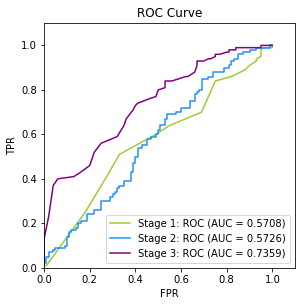

In [31]:
plt.figure(figsize=(4.5, 4.5))
plt.xlim(0., 1.1)
plt.ylim(0., 1.1)
plt.plot(fpr1, tpr1, color='yellowgreen', label='Stage 1: ROC (AUC = %0.4f)' % auc_score1)
plt.plot(fpr2, tpr2, color='dodgerblue', label='Stage 2: ROC (AUC = %0.4f)' % auc_score2)
plt.plot(fpr3, tpr3, color='purple', label='Stage 3: ROC (AUC = %0.4f)' % auc_score3)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig('baard_roc_cw2_0.pdf', format='pdf', dpi=400, bbox_inches='tight')

In [34]:
output = {
    'fpr1': fpr1,
    'fpr2': fpr2,
    'fpr3': fpr3,
    'tpr1': tpr1,
    'tpr2': tpr2,
    'tpr3': tpr3,
}
torch.save(output, 'baard_roc_resnet_cw2_0')

In [25]:
# qs = [1. - i*0.01 for i in range(20)]
# s2.verbose = 0
# for q in qs:
#     s2.quantile = q
#     s2.search_thresholds(X_def_val, y_def_val, np.zeros_like(y_def_val))
#     output_X = s2.predict(X_def_val, y_def_val)
#     print(np.sum(output_X))

0
10
10
10
10
10
10
11
11
12
12
14
15
16
17
19
19
22
22
22


In [26]:
# s3.quantile = 1.0
# s3.search_thresholds(X_def_val, y_def_val, np.zeros_like(y_def_val))
# output_X = s3.predict(X_def_val, y_def_val)
# np.sum(output_X)

Decidability: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


0